In [1]:
# In this jupyter notebook, we will check the responses collected online for completeness. 
# Also, we will perform some basic sanity checks.
# We will first load the data from a json file and transform it into a pandas data frame. 
# Next, we will make sure to reformat that data frame such that every row is one trial (the json file will give us
# one row for every event)

### Inclusion Criteria 
1. completeness:

every participant has done the same number of trials

2. screen requirements

height and width support full stimulus presentation

screen was not tilted during trials (orientation always the same)

3. responses in survey

participants responded with the index finger

concentration rating at least neutral

fullscreen worked

no comments about missunderstanding etc.

4. data quality

for jump trials: error on jumped trials gets smaller with shorter SOAs (response adjusted to jump)

for serial trials: touch position better explained by true location than by mean (response targeted dots)

#### TODO: 

sumarize checks in functions, run individually for participants

In [2]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Define a custom color map
top = plt.cm.get_cmap('Greens_r', 128)
bottom = plt.cm.get_cmap('Greys', 128)

shiftcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
shiftcmp = cls.ListedColormap(shiftcolors, name='GnGy')

In [3]:
data = {}
# load data from different components:

# the experimental component
exp_data =  open('../data/jatos_results_09_08.txt')
# unpack the data
for ses, jf in enumerate(exp_data):
    
    # save it to a data frame
    jd = json.loads(jf)
    df = pd.DataFrame(jd)
    df['session'] = ses

    try:
        data = pd.concat([data,df], axis = 0)
        #print('fail')
    except:
        data = df
data.reset_index(drop = True, inplace = True)
data

,view_history,rt,test_part,trial_type,trial_index,time_elapsed,internal_node_id,subject,screenWidth,screenHeight,...,choiceOrder,button-x,button-y,jump-x,jump-y,orderResponse,responses,survey_response,docTouches,allTouches
0,"[{""page_index"":0,""viewing_time"":4330.400000006...",4331.4,general_welcome,instructions,0,4339,0.0-0.0,3961,640.0,360.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{""page_index"":0,""viewing_time"":2302.700000000...",5692.8,general_intro,instructions,1,10235,0.0-1.0,3961,640.0,360.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,21940.2,NaN,image-button-response,2,33193,0.0-2.0,3961,640.0,360.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,43996.3,NaN,image-button-response,3,77194,0.0-3.0,3961,640.0,360.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{""page_index"":0,""viewing_time"":13223.50000002...",13227.1,general_intro,instructions,0,13238,0.0-0.0,3961,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8669,NaN,2546.0,outro_concentration,survey-likert,0,2555,0.0-0.0-0.0,3924,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"{""Q0"":0}",Concentrated,NaN,NaN
8670,NaN,955.0,outro_finger,html-button-response,1,3525,0.0-0.0-1.0,3924,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,index,NaN,NaN
8671,NaN,1141.0,outro_screen,html-button-response,2,4670,0.0-0.0-2.0,3924,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN
8672,NaN,7449.5,outro_comments,survey-text,3,12145,0.0-0.0-3.0,3924,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clara 1,NaN,NaN


In [4]:
# Import jatos meta data
jatos_meta = pd.read_csv('../data/jatos_meta.csv')
jatos_meta

,Result ID,Start Time,Last Seen,Duration,Batch,Worker ID,Worker Type,MTurk Worker ID (Confirmation Code),State,Message
0,3886,2021/08/08 21:49:54,2021/08/08 22:23:40,00:35:21,Default,3961,General Multiple,none(none),FINISHED,none
1,3880,2021/08/06 09:01:42,2021/08/06 09:32:59,00:31:52,Default,3954,General Multiple,none(none),FINISHED,none
2,3870,2021/08/05 17:46:31,2021/08/05 18:09:42,00:23:28,Default,3946,General Multiple,none(none),FINISHED,none
3,3867,2021/08/05 15:58:02,2021/08/05 16:20:28,00:22:40,Default,3943,General Multiple,none(none),FINISHED,none
4,3865,2021/08/05 12:26:05,2021/08/05 12:55:01,00:29:19,Default,3941,General Multiple,none(none),FINISHED,none
5,3851,2021/08/04 13:19:21,2021/08/04 13:44:02,00:25:00,Default,3925,General Multiple,none(none),FINISHED,none
6,3850,2021/08/04 11:55:40,2021/08/04 12:21:35,00:26:08,Default,3924,General Multiple,none(none),FINISHED,none


In [5]:
# save a data frame for only the trials
# jump data

def load_missing_data(component, result_id):
    """
    function that tries to load the missing data from result files
    
    INPUT: 
    component: string, the experimental component we want to load ("Trials_Jump" or "Trials_Serial")
    result_id: the ID of the result component (depends on the subject ID)
    
    OUTPUT:
    df: pd data frame or None 
    """
    
    # get the directory name
    dir_name = '../data/jatos_resultfiles/study-result_{}'.format(result_id)
    # list all directories there
    subdirs = os.listdir(dir_name)
    for subdir in subdirs:
        
        # check if the directory includes result files
        if 'comp-result' in subdir:
            # load file
            file = '{}/{}/trialData.json'.format(dir_name, subdir)
            jo = open(file)
            jl = json.load(jo)
            df = pd.DataFrame(jl)
            # check if the component is what we want it to be
            if np.unique(df.component) == component:
                # return
                return df

    
def parse_load_data(data, components, meta):
    """
    Function to parse data into several components and load elements that are fully missing from the result files
    
    INPUT
    data: pd dataframe, the full data frame
    components: list of strings the experimental components we want to parse in individual DFs 
    meta: pd dataframe - contains the mapping from subject ID to result IDs
    
    OUTPUT
    component_list: list of pd dfs, one per component
    """
    
    # initialize empty component list
    component_list = []
    # load a subject list
    subject_list = np.unique(data.subject)
    
    # loop through all defined components
    for component in components:
        
        # filter data from df
        comp_df = data[data.component == component]
        
        # loop through all subjects
        for subject in subject_list:
            
            # filter the component df
            sub_df = comp_df[comp_df.subject == subject]
            
            # check if the subject has not completed any trial in that component
            if len(sub_df) == 0:
                
                # get the resul ID
                resultID = meta[meta['Worker ID'] == int(subject)]['Result ID'].values[0]
                # try to load missing data
                sub_df = load_missing_data(component, resultID)
                # append the loaded df to the full df
                comp_df = pd.concat([comp_df, sub_df], ignore_index = True)
        # fill the component list   
        component_list.append(comp_df)
    
    return component_list

# parse data frame into jdf and sdf                
jdf, sdf = parse_load_data(data, ['Trials_Jump', 'Trials_Serial'], jatos_meta)

# filter the data for trials that were actually shown (and not skipped)
def filter_trials(data, filter_dict):
    """
    Function to filter the relevant parts out of a large data frame
    
    INPUT:
    data: a pd data frame
    filter_dict: a dictionary containing the name as the column as key and the value that the column should have as value
    
    OUTPUT:
    df: the filtered data frame
    """
    # make a copy of the data file
    df = data.copy()
    
    # loop through the entries of the dictionary
    for filter_crit in filter_dict:
        # this is the actual filter
        df = df[df[filter_crit] == filter_dict[filter_crit]]
        
    # return
    return df

# first, get only trials that were indeed shown
# refactor some old variables
sdf.loc[:,'test_part'] = sdf['test_part'].replace({'Serial-Inhibition': 'trial'})

# filter only data from trial components (omitting feedback lines)
j_dataTrial = filter_trials(jdf, {'test_part': 'trial'}) 
s_dataTrial = filter_trials(sdf, {'test_part': 'trial'}) 

# then, get those that were valid
j_data = filter_trials(jdf, {'lateResponse': False, 'earlyResponse': False})
s_data = filter_trials(sdf, {'lateResponse': False, 'orderResponse': True})

# and compute the proportion of valid trials
print('There were {}% invalid trials in the jump task.'.format((len(j_dataTrial) - len(j_data))*100/len(j_dataTrial)))
print('There were {}% invalid trials in the serial task.'.format((len(s_dataTrial) - len(s_data))*100/len(s_dataTrial)))


# potentially, we need to reconstruct the time when the go signal was given. 
j_data.loc[np.isnan(j_data.goSignalTime),'goSignalTime'] = j_data[np.isnan(j_data.goSignalTime)].goTime - j_data[np.isnan(j_data.goSignalTime)].rt

There were 7.628865979381444% invalid trials in the jump task.
There were 7.885554780181438% invalid trials in the serial task.


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [6]:
# get a list of participants
subjects = np.unique(data.subject)

In [7]:
# completeness check

list_jump = []
list_serial = []

for s in subjects:
    
    jump = len(j_data[j_data.subject == s])
    serial = len(s_data[s_data.subject == s])
    
    list_jump.append(jump)
    list_serial.append(serial)
    
    print('subject {} completed {} jump trials and {} serial trials'.format(s, jump, serial))

print('there was one unique length of jump trials: {}'.format(len(np.unique(list_jump)) == 1))
print('there was one unique length of serial trials: {}'.format(len(np.unique(list_serial)) == 1))

subject 3924 completed 192 jump trials and 160 serial trials
subject 3925 completed 192 jump trials and 160 serial trials
subject 3941 completed 192 jump trials and 200 serial trials
subject 3943 completed 192 jump trials and 200 serial trials
subject 3946 completed 192 jump trials and 200 serial trials
subject 3954 completed 192 jump trials and 200 serial trials
subject 3961 completed 192 jump trials and 200 serial trials
there was one unique length of jump trials: True
there was one unique length of serial trials: False


what these columns mean: 
1. 'view_history': for jsPsych instruction components, how long each page was looked at, 
2. 'rt': online computed reaction time
3. 'test_part': with trial type is currently run
4. 'trial_typ': which java script code was used for the event
5. 'trial_index': running number through all events
6. 'time_elapsed': time stamp at the end of the event
7. 'internal_node_id': idk
8. 'subject': jatos worker ID
9. 10. 'screenWidth, screenHeight': information about screen size
11. 'userInfo': device and browser information
12. 'platform': os
13. 'scrPixDepth': pixel Depth
14. 'scrColDepth': color Depth
15. 'scrOrientation': landscape or portrait
16. 'scrResolution': number of pixels per html pixel
17. 'component': the which jatos component is currently active
18. 'stimulus': html for stimulus presentation
19. 'response': jsPsych response for button choices
20. 'session': homebrew id for every component
21. 'button_pressed': jsPsych response for button presses
22. 'touchX': the X coordinate for down presses
23. 'touchY': the Y coordinate for Y presses
24. 'liftX': the X coordinate for fingers lifted from the screen
25. 'liftY': the Y coordniate for fingers lifted from the screen
26. 'js_start': time stamp beginning of the event
27. 'js_touchdown': time stamps of the response
28. 'js_end': time stamp of data writeout
29. 'button0-x': the x coordinate of the first button
30. 'button0-y': the y coordinate of the first button
31. 'all_touches': monitors all touches across the screen
32. 'js_touchup': time stamp of lift
33. 'mt': movement time - duration the finger was in air
34. 'cTouchX': the x coordinate where the center of the screen was touched
35. 'cTouchY': the y coordinate where the center of the screen was touched
36. 'sTouchX': the x coordinate where the side stimulus was touched
37. 'sTouchY': the y coordinate where the side stimulus was touches
38. 'startTime': for jump trials the time when the central dot appeared, for serial trials the time when the first point was touched
40. 'goSignalTime': the time when the central dot jumped to the side in the jump task
41. 'goTime': the time the response started (finger was lifted from the center) in the jump task
42. 'flashOnTime': the time when the flash was shown
43. 'flashOffTime': the time when the flash was turned off again
44. 'waitTime': the time the central dot was on the screen before it was touched
45. 'earlyResponse': if the response was given bfore the go signal
46. 'lateResponse': if the response was too slow
47. 'trialShown': if the trial was presented or not
48. 'errors': information logged to the console
49. 'sideX': X location of the dot on the side
50. 'sideY': Y location of the dot on the side
60. 'centralX': X location of the central point
61. 'centralY': Y location of the central point
62. 'jumpedX': X location of the dot after a jump
63. 'jumpedY': Y location of the dot after a jump
64. 'docTouches': responses across the document (also not in the valid response areas, Jump Task)
65. 'position': if the jump was left or righ
66. 'stimJumped': if the stimulus was shifted a second time or not
67. 'flashShown': if the flash appeared or not
68. 'inwards': if the shift was inwards or outwards
69. 'fixTime': how long the central point was shown before the jump
70. 'flashTime': when the flash was shown
71. 'trialDuration': the maximum duration of the trial (jump task)
72. 'trialID': an individual ID for each trial
73. 'tDur': the duration of the trial (serial task)
74. 'endTime': the time when the data was saved
75. 'respTime': the time when a response was given (jsPsych components)
76. 'success': if the trial was completed
77. 'touchOn': times when touch onsets were detected
78. 'touchOff': times when lifts were detected
79. 'choiceOrder': the order in which the targets were touched
80. 'allTouches': responses across the document (also not in the valid response areas, Serial Task)
81. 'orderResponse': true/false if the order was correct
82. 'responses': jspsych response parameter

In [8]:
# screen size check
# collect meta data
mdf = pd.DataFrame(columns = ['WidthCSS', 'HeightCSS', 'WidthPix', 'HeightPix',  'CenterX', 'CenterY',
                              'Device', 'Platform', 
                              'scrPixDepth', 'scrColDepth', 'scrOrientation', 'scrResolution'])

# the meta data is saved in different components. In the experimental component, 
# we saved meta information in the "welcome" part
# the welcome data frame
wdf = data[data.test_part == 'general_welcome']

for row,idx in enumerate(wdf.index):
    mdf.loc[row,'WidthCSS'] = max(wdf.screenWidth[idx], wdf.screenHeight[idx])
    mdf.loc[row,'HeightCSS'] = min(wdf.screenWidth[idx], wdf.screenHeight[idx])
    try:
        mdf.loc[row,'WidthPix'] = wdf['pixWidth'][idx]
        mdf.loc[row,'HeightPix'] = wdf['pixHeight'][idx]
    except:
        pass
    mdf.loc[row,'Device'] = wdf.userInfo[idx]
    mdf.loc[row,'Platform'] = wdf.platform[idx]
    mdf.loc[row,'scrPixDepth'] = wdf.scrPixDepth[idx]
    mdf.loc[row,'scrColDepth'] = wdf.scrColDepth[idx]
    mdf.loc[row,'scrOrientation'] = wdf.scrOrientation[idx]
    mdf.loc[row,'scrResolution'] = wdf.scrResolution[idx]

# set min width
# set min height
min_width = 600
min_height = 300

print('All of the displays had at least the minimal width: {}'.format(np.all(mdf.WidthCSS >= min_width)))
print('All of the displays had at least the minimal height: {}'.format(np.all(mdf.HeightCSS >= min_height)))

All of the displays had at least the minimal width: True
All of the displays had at least the minimal height: True


In [9]:
# check the orientation of the phone 

def check_orientation(data):
    
    """
    Function to check the orientation of participant's screens
    
    INPUT:
    data: the dataframe with orientation information from each trial
    """
    
    # get the number of unique orientation entries without NA 
    ori_length = len(np.unique(data.scrOrientation.dropna()))
    # get the subject
    sub = np.unique(data.subject)[0]
    # get the component
    comp =np.unique(data.component)[0]
    
    # check if there was more than one orientation detected
    if ori_length > 1:
        
        print('subject {} turned their phone in component {}'.format(sub, comp))
   
    # check if there was less than one entry for orientation
    elif len(np.unique(data.scrOrientation.dropna())) < 1:
        
        print('no screen orientation available for subject {}, component {}'.format(sub, comp))

def check_central_position(jump_data):
    
    """
    check if the x/y coordinates changed to different values (indicator for changes in screen)
    
    INPUT: 
    jump_data: pd data frame from the jump condition
    """
    
    # get the number of unique x positons of the central dot 
    xCentral_length = len(np.unique(jump_data.centralX.dropna()))
    yCentral_length = len(np.unique(jump_data.centralY.dropna()))
    # get the subject
    sub = np.unique(jump_data.subject)[0]
    
    if xCentral_length > 1:
        print('{} different x positions of the central dot for subject {}.'.format(xCentral_length, sub))
        
    if yCentral_length > 1:
        print('{} different y positions of the central dot for subject {}.'.format(yCentral_length, sub))
        

def check_position_outlier(serial_data, jitter):
    
    """
    check if there were any extreme outliers for the first dot in the serial sequence 
    
    INPUT: 
    serial_data: data points from the serial task
    jitter: the jitter that was allowed by the experiment
    """
    
    # get the mean of x and y on the first dot 
    xfirst = [serial_data['button-x'][idx][0] for idx in serial_data.index]
    yfirst = [serial_data['button-y'][idx][0] for idx in serial_data.index]
    
    # get the difference for each do to the mean
    xdiff = xfirst - np.mean(xfirst)
    ydiff = yfirst - np.mean(yfirst)

    # get the subject
    sub = np.unique(serial_data.subject)[0]
    
    if any(abs(xdiff) > jitter): 
        print('first dot(s) off by {} along x axis for subject {}.'.format(xdiff[abs(xdiff)>jitter], sub))
        
    if any(abs(ydiff) > jitter): 
        print('first dot(s) off by {} along y axis for subject {}.'.format(ydiff[abs(ydiff)>jitter], sub))
        
    
    

# loop through all subjects
for subject in subjects:
    # get a data frame for the subject
    js_data = j_data[j_data.subject == subject]
    ss_data = s_data[s_data.subject == subject]
    
    # check orientation here
    check_orientation(js_data)
    check_central_position(js_data)
    check_orientation(ss_data)
    check_position_outlier(ss_data,25)

first dot(s) off by [ 25.35594649  25.26112838  25.55519576  25.40997787  26.47008224
  26.6530046  -36.63245683 -46.58790116 -40.99875932 -45.62699418
 -30.59078507 -37.89608293 -31.07444291 -29.76252275 -41.54296403
 -25.40236955 -32.35656266 -26.83112626 -28.5180922  -32.20855241
 -38.22880082 -49.49335008 -43.70354753 -44.70728593 -26.92371659] along y axis for subject 3924.
2 different x positions of the central dot for subject 3943.
2 different y positions of the central dot for subject 3943.
no screen orientation available for subject 3946, component Trials_Jump
2 different x positions of the central dot for subject 3946.
2 different y positions of the central dot for subject 3946.
no screen orientation available for subject 3946, component Trials_Serial
first dot(s) off by [-126.12942123] along x axis for subject 3946.
first dot(s) off by [141.90137024] along y axis for subject 3946.
2 different x positions of the central dot for subject 3954.
2 different y positions of the cen

In [10]:
# collect survey data
survey_df = data[data.component == 'Outro_General']

In [11]:
# check if there are missing responses from a participant: 

for s in subjects: 
    
    if len(sdf[sdf.subject == s]) == 0:
        
        print('subject {} did not complete the survey'.format(s))

comments: 
1012                   No
1975                     
2870    Clara Screen flip
6611         Clara tablet
8672              Clara 1
Name: survey_response, dtype: object


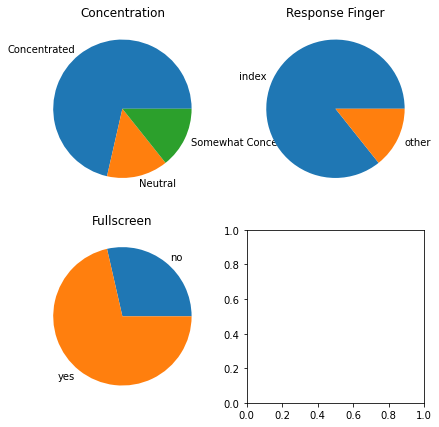

In [22]:
# check survey
# plot the distribution of responses in pie charts
def get_pie_parts(data_series):
    
    """
    Computes the percentage of responses in each category
    
    INPUT:
    data_series: a pd series with 1 entry/subject
    
    OUTPUT: 
    parts: a list of the portion of each response 
    names: the labels of the responses
    """
    
    # compute the length of the full series
    full_length = len(data_series)
    # set up an array for the part
    parts = []
    # get the names
    names = np.unique(data_series)
    
    # loop through all names
    for name in names:
        # append how often this answer was given
        parts.append(sum(data_series == name))
    # divide by the number of total 
    parts = np.array(parts)/full_length
    
    return parts, names

# set up the figure
fig, axs = plt.subplots(2,2, figsize = (7,7))

# Question 1: "Indicate your concentration"
axs[0,0].set_title('Concentration')
parts_concentration, names_concentration = get_pie_parts(survey_df[survey_df.test_part == 'outro_concentration'].survey_response)
axs[0,0].pie(parts_concentration, labels = names_concentration);

# Question 2: "Which finger did you use"
axs[0,1].set_title('Response Finger')
parts_finger, names_finger = get_pie_parts(survey_df[survey_df.test_part == 'outro_finger'].survey_response)
axs[0,1].pie(parts_finger, labels = names_finger);

# Question 3: "Did the screen switch to fullscreen?"
axs[1,0].set_title('Fullscreen')
parts_screen, names_screen = get_pie_parts(survey_df[survey_df.test_part == 'outro_screen'].survey_response)
axs[1,0].pie(parts_screen, labels = names_screen);

# Print all the comments that were given
print('comments: ')
print(survey_df[survey_df.test_part == 'outro_comments'].survey_response.dropna())

In [13]:
survey_df[['test_part','subject','survey_response']]

,test_part,subject,survey_response
1009,outro_concentration,3961,Concentrated
1010,outro_finger,3961,index
1011,outro_screen,3961,yes
1012,outro_comments,3961,No
1013,outro_bye,3961,NaN
1972,outro_concentration,3954,Neutral
1973,outro_finger,3954,index
1974,outro_screen,3954,no
1975,outro_comments,3954,
1976,outro_bye,3954,NaN


In [14]:
s_data.columns

Index(['view_history', 'rt', 'test_part', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'subject', 'screenWidth',
       'screenHeight', 'userInfo', 'platform', 'scrPixDepth', 'scrColDepth',
       'scrOrientation', 'scrResolution', 'component', 'stimulus', 'response',
       'session', 'button_pressed', 'touchX', 'touchY', 'liftX', 'liftY',
       'js_start', 'js_touchdown', 'js_touchup', 'js_end', 'button0-x',
       'button0-y', 'all_touches', 'mt', 'tDur', 'cTouchX', 'cTouchY',
       'sTouchX', 'sTouchY', 'startTime', 'endTime', 'goTime', 'waitTime',
       'earlyResponse', 'lateResponse', 'trialShown', 'sideX', 'sideY',
       'centralX', 'centralY', 'jumpedX', 'jumpedY', 'errors', 'position',
       'stimJumped', 'flashShown', 'inwards', 'fixTime', 'flashTime',
       'trialDuration', 'trialID', 'goSignalTime', 'flashOnTime',
       'flashOffTime', 'respTime', 'success', 'touchOn', 'touchOff',
       'choiceOrder', 'button-x', 'button-y', 'jump-x', 'jum

In [15]:
jumpColumns = ['subject','trialID', 'rt', 'mt', 'tDur', 'cTouchX', 'cTouchY','sTouchX', 'sTouchY', 
               'startTime', 'endTime', 'goSignalTime', 'goTime', 'waitTime',
               'sideX','sideY', 'centralX', 'centralY', 'jumpedX', 'jumpedY', 'docTouches',
               'position', 'stimJumped', 'flashShown', 'inwards', 
               'fixTime', 'flashTime', 'trialDuration', 'flashOnTime', 'flashOffTime', 'respTime']

j_data = j_data[jumpColumns]

serialColumns = ['subject','trialID', 'touchX', 'touchY', 'button-x', 'button-y', 'jump-x', 'jump-y', 
                 'tDur', 'startTime', 'endTime', 'waitTime', 'flashTime',  
                 'flashOnTime', 'flashOffTime','touchOn', 'touchOff', 'stimJumped']

s_data = s_data[serialColumns]

# compute the onset relative to the start
def relate_to_onset(data, cols, startcol):
    
    """
    Function that align the columns relative to one particular event
    
    INPUT:
    data: a pandas data frame that holds the relevant columns
    cols: a list of all column names that should be aligned
    startcol: the name of the column that serves as onset value
    
    OUTPUT
    The aligned data frame, with an extra column "sync" where the start values are saved.

    """
   
    # save the start column values in the first variable
    data.loc[:]['sync'] = data[startcol]
    
    # loop through all columns
    for col in cols:
        
        try: 
            # subtract the value of the start column
            data.loc[:][col] = data[col]-data[startcol]
            
        except TypeError:
            # if the column holds a list, use list comprehension to extract the values
            data.loc[:][col] = [np.array(data[col][x]) - data[startcol][x] for x in data.index]
    
    return data

# define the columns that contain timing information
jump_timing = ['startTime', 'endTime', 'goTime','fixTime', 'flashOnTime', 'flashOffTime', 'respTime']
# apply alignment to jump data
df_jump = relate_to_onset(j_data.copy(), jump_timing, 'goSignalTime')

# add one column that indicates the onset relative to the flash
df_jump['goAfterFlashTime'] = df_jump['goTime'] - df_jump['flashOnTime']

# repeat for serial data
serial_timing = ['endTime', 'waitTime', 'flashOnTime', 'flashOffTime','touchOn', 'touchOff']
df_serial = relate_to_onset(s_data.copy(), serial_timing, 'startTime')
# reverse the order of buttons
for x in df_serial.index:
    df_serial['button-x'][x].reverse()
    df_serial['button-y'][x].reverse() 
    df_serial['jump-x'][x].reverse() 
    df_serial['jump-y'][x].reverse() 
    
    

In [16]:
df_jump.columns

Index(['subject', 'trialID', 'rt', 'mt', 'tDur', 'cTouchX', 'cTouchY',
       'sTouchX', 'sTouchY', 'startTime', 'endTime', 'goSignalTime', 'goTime',
       'waitTime', 'sideX', 'sideY', 'centralX', 'centralY', 'jumpedX',
       'jumpedY', 'docTouches', 'position', 'stimJumped', 'flashShown',
       'inwards', 'fixTime', 'flashTime', 'trialDuration', 'flashOnTime',
       'flashOffTime', 'respTime', 'goAfterFlashTime'],
      dtype='object')

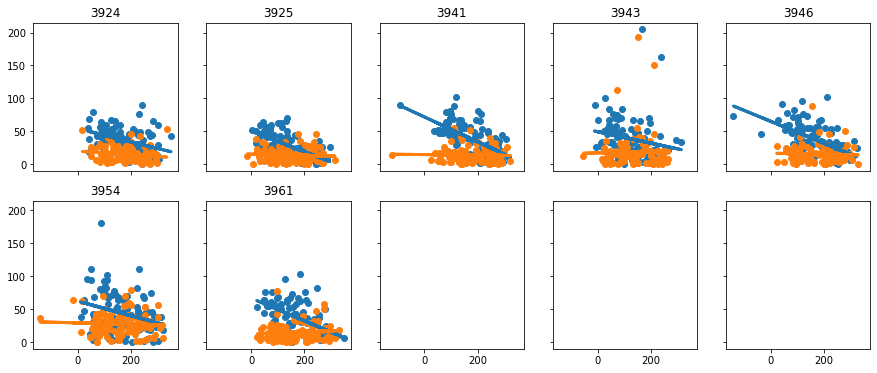

In [17]:
# Check data quality jump:
# error response - jumped target decreases with time

# compute the x error relative to the jumped dot
df_jump['xError'] = df_jump.jumpedX - df_jump.sTouchX
df_jump['soa'] = df_jump.goTime - df_jump.flashTime

def check_soa_xerror_correlation(subjects, data):
    
    """
    Check if the touch error on jump trials decreases with longer processing time.
    This function creates plots for every subject and prints an alert if the regression looked weird
    
    INPUT:
    subjects: array of all subjects
    data: pd dataframe from the jump component with all subjects
    
    OUTPUT:
    None
    """
    
    # get the subjects
    nsubs = len(subjects)
    # always plot 5 columns
    plotcols = 5
    # plot as many rows as needed
    plotrows = int(np.ceil(nsubs/plotcols))
    # plot panels are 3x3
    size_per_panel = 3
    
    # initialize the plots
    fig_soa_xerror, axs_soa_xerror = plt.subplots(plotrows,plotcols, figsize = (size_per_panel * plotcols, size_per_panel * plotrows), sharex = True, sharey = True)
    
    # loop over all subjects
    for s_idx, s in enumerate(subjects):
        
        # filter the data per subject
        s_df = data[data.subject == s]
        
        # split data in jump and stay
        jump_idx = s_df.stimJumped == 1.0
        stay_idx = s_df.stimJumped == 0.0
    
        # distance from mean error 
        x_error_jump = abs(s_df[jump_idx].xError - np.mean(s_df[jump_idx].xError))
        x_error_stay = abs(s_df[stay_idx].xError - np.mean(s_df[stay_idx].xError))

        # 1. plot
        axs_soa_xerror.flatten()[s_idx].scatter(s_df[jump_idx].soa, x_error_jump)
        axs_soa_xerror.flatten()[s_idx].scatter(s_df[stay_idx].soa, x_error_stay)
        axs_soa_xerror.flatten()[s_idx].set_title(s)
        
        # 2. build regression
        
        # 2. linear regression
        regr_jump = linear_model.LinearRegression()
        regr_jump.fit(s_df[jump_idx].soa.values.reshape(-1,1), x_error_jump.values.reshape(-1,1))

        regr_stay = linear_model.LinearRegression()
        regr_stay.fit(s_df[stay_idx].soa.values.reshape(-1,1), x_error_stay.values.reshape(-1,1))

        x_error_jump_pred = regr_jump.predict(s_df[jump_idx].soa.values.reshape(-1,1))
        x_error_stay_pred = regr_stay.predict(s_df[stay_idx].soa.values.reshape(-1,1))
    
        axs_soa_xerror.flatten()[s_idx].plot(s_df[jump_idx].soa, x_error_jump_pred, linewidth = 3);
        axs_soa_xerror.flatten()[s_idx].plot(s_df[stay_idx].soa, x_error_stay_pred, linewidth = 3);
        
        # check two conditions:
        
        # cond1 : the correlation coefficient for the jump task should be negative
        if regr_jump.coef_ >=0: 
            print('subject {} has a non-negative correlation between SOA and x-Error. The computed coeffiecient was: {}'.format(s, regr_jump.coef_))
        
        # cond2: the correlation. coefficient for jump is more negative than the correlation coefficient for stay
        if regr_stay.coef_< regr_jump.coef_ :
            
            print('the correlation between SOA and x-Error was more negative in the stay condition.')
            print('Subject: {}'.format(s))
            print('Coeffient jump: {}'.format(regr_jump.coef_))
            print('Coeffient stay: {}'.format(regr_stay.coef_))
            
# check the regression       
check_soa_xerror_correlation(subjects, df_jump)

In [18]:
# transform the serial data set to one column for each button touch

# initialize lists fro the columns
X_touch_colnames = [] 
Y_touch_colnames = []
X_target_colnames = []
Y_target_colnames = []
time_colnames = []
lift_colnames = []

# for all targets that will be touched
for tar in range(0,6):
    
    timeOn_name = 'touchOnTime_tar{}'.format(tar)
    x_touch_name  = 'touchX_tar{}'.format(tar)
    y_touch_name  = 'touchY_tar{}'.format(tar)
    x_target_name = 'targetX_tar{}'.format(tar)
    y_target_name = 'targetY_tar{}'.format(tar)
    
    # add these names to their lists 
    X_touch_colnames.append(x_touch_name)
    Y_touch_colnames.append(y_touch_name)
    X_target_colnames.append(x_target_name)
    Y_target_colnames.append(y_target_name)
    time_colnames.append(timeOn_name)
    
    # extract lists of each
    timeOn_tar = [df_serial.touchOn[x][tar] for x in df_serial.index]
    X_touch = [df_serial.touchX[x][tar] for x in df_serial.index] 
    Y_touch = [df_serial.touchY[x][tar] for x in df_serial.index] 
    X_target = [df_serial['button-x'][x][tar] for x in df_serial.index] 
    Y_target = [df_serial['button-y'][x][tar] for x in df_serial.index] 
    
    
    # save in df
    df_serial[timeOn_name] = timeOn_tar
    df_serial[x_touch_name] = X_touch
    df_serial[y_touch_name] = Y_touch
    df_serial[x_target_name] = X_target
    df_serial[y_target_name] = Y_target
    
    # lift times will be tracked for the first 5 lifts
    if tar < 5:
        timeOff_name = 'touchOff_time_{}'.format(tar)
        lift_colnames.append(timeOff_name)
        
        timeOff_tar = [df_serial.touchOff[x][tar] for x in df_serial.index]
        
        df_serial[timeOff_name] = timeOff_tar

something went wrong with subject 3924
something went wrong with subject 3925


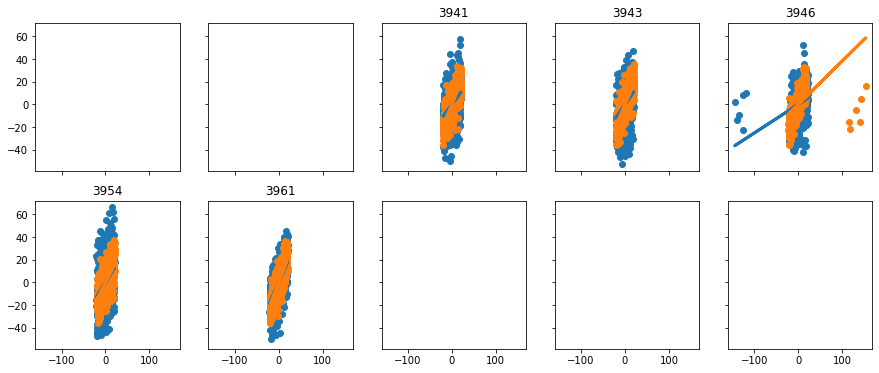

In [21]:
# Sanity check: the if touch coordinates are correlated with the position of each dot. 

# step 1: only data without a step
df_nojump = df_serial[df_serial['stimJumped'] == 0.0]

def check_touch_target_correlation(subjects, data):
    
    """
    check if the touch response correlates with the position of the dots on the screen
    prints a plot with the correlation
    
    INPUT:
    subjects: a list of all subjects that participated
    data: a pd dataframe of the component
    
    OUTPUT:
    None
    """
    
    # get the number of all subjects
    nsubs = len(subjects)
    # always plot 5 columns
    plotcols = 5
    # define the needed number of rows
    plotrows = int(np.ceil(nsubs/plotcols))
    # plot panels have size 3x3
    size_per_panel = 3
    # initialize the figure
    fig_touch_target, axs_touch_target = plt.subplots(plotrows,plotcols, figsize = (size_per_panel * plotcols, size_per_panel * plotrows), sharex = True, sharey = True)
    
    # loop through all subjects
    for s_idx, s in enumerate(subjects):
        
        try:
        
            # filter the dataframe
            sdf = data[data.subject == s].copy()

            # step 1.1.: correct the y position with 
            sdf.loc[sdf.index, X_target_colnames] -= sdf[X_target_colnames].mean()
            sdf.loc[sdf.index, Y_target_colnames] -= sdf[Y_target_colnames].mean()

            sdf.loc[sdf.index, X_touch_colnames] -= sdf[X_touch_colnames].mean()
            sdf.loc[sdf.index, Y_touch_colnames] -= sdf[Y_touch_colnames].mean()


            # step 2: make a long list of the x positions
            x_targets = pd.concat([sdf[x] for x in X_target_colnames], axis = 0, ignore_index = True)
            y_targets = pd.concat([sdf[x] for x in Y_target_colnames], axis = 0, ignore_index = True)

            x_touches = pd.concat([sdf[x] for x in X_touch_colnames], axis = 0, ignore_index = True)
            y_touches = pd.concat([sdf[x] for x in Y_touch_colnames], axis = 0, ignore_index = True)

            # step 3: plot the correlation between x position and x touch 
            axs_touch_target.flatten()[s_idx].scatter(x_targets, x_touches)
            axs_touch_target.flatten()[s_idx].scatter(y_targets, y_touches)

            # step 4: fit the regression
            regr_X = linear_model.LinearRegression()
            regr_X.fit(x_targets.values.reshape([-1,1]), x_touches.values.reshape([-1,1]))

            regr_Y = linear_model.LinearRegression()
            regr_Y.fit(y_targets.values.reshape([-1,1]), y_touches.values.reshape([-1,1]))

            x_touches_pred = regr_X.predict(x_targets.values.reshape([-1,1]))
            y_touches_pred = regr_Y.predict(y_targets.values.reshape([-1,1]))

            axs_touch_target.flatten()[s_idx].plot(x_targets, x_touches_pred, linewidth = 3);
            axs_touch_target.flatten()[s_idx].plot(y_targets, y_touches_pred, linewidth = 3);
            axs_touch_target.flatten()[s_idx].set_title(s)
            
            # TODO: define and check regression conditions: 
        except ValueError:
            print('something went wrong with subject {}'.format(s))

# run the check
check_touch_target_correlation(subjects, df_nojump)